<span style="color:SteelBlue; font-size:42px;">Single Object Detection</span> 
<hr>

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
#torch.cuda.set_device(1)

`torch.cuda.set_device(1)`: if more than 1 GPU, set appropriately.

## Single Object classification
**Objecive 1:** to put **bounding boxes** around what we see: this is a box/rectangle, with object fitting entirely within it. 

**Objecive 2:** to take data that has been labelled in this way, and on data that is unlabelled to generate the classes of the objects and for each one of those their bounding boxes.

**Steps**:
1. Classify and localize WHAT is the largest object in the each image
2. WHERE is the object located in each image, using bounding boxes.
3. Combine 1 and 2: WHAT and WHERE is the largest image.

<img src="images/8_3.png">

## Pascal VOC dataset
- this project will use Pascal "Visual Object Classes" (VOC) dataset
- Provides standardised image data sets for object class recognition research

Data source: [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) or from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different research datasets, from 2007 and 2012. The following analysis is from 2007 version.

In [4]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/.DS_Store'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

- `Path('data/pascal')`: gives you object oriented access to a directory or file.

In [5]:
PATH.iterdir()

<generator object Path.iterdir at 0x1218f38e0>

- `PATH.iterdir()`: returns generator object, which iterates over the files in specified directory, but not until you call it. Geneartors are good, because what if you had 10,000,000 items in the direcotory? You do not neccessarily want all of those items, so with a for loop allows you to grab 1, throw it away, grab the next one, throw away, etc. I.e, lets you do things "lazily".

In [6]:
# Example of the PATH.iterdir()
for i in PATH.iterdir(): print(i)

data/pascal/.DS_Store
data/pascal/pascal_test2007.json
data/pascal/pascal_train2007.json
data/pascal/pascal_train2012.json
data/pascal/pascal_val2007.json
data/pascal/pascal_val2012.json
data/pascal/PASCAL_VOC.zip
data/pascal/tmp
data/pascal/VOCdevkit
data/pascal/VOCtrainval_06-Nov-2007.tar


nb: Can do the same thing with a list comprehension:

In [6]:
[i for i in PATH.iterdir()]

[PosixPath('data/pascal/.DS_Store'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

Or you can just stick `list` aournd it to turn the generator into a list:

In [7]:
list(PATH.iterdir())

[PosixPath('data/pascal/.DS_Store'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

Lets just grab one:

In [8]:
o = list(PATH.iterdir())[1]
o

PosixPath('data/pascal/pascal_test2007.json')

What is reutrned is some kind of object,  not really a string. Python won't choke on it most of the time. If it does choke, can change the datatype in python:

In [9]:
str(o)

'data/pascal/pascal_test2007.json'

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so will use the more recent JSON version downloaded from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

In [10]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

`trn_j`: loaded json file called 'pascal_train2007.json', which contain, not the images, but a dictionary with the bounding boxes and classes of the objects.

In [11]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

`IMAGES`: shows the file name, their height, a unique id, and the width. Have taken the word 'images' and put inside a constant called `IMAGES`. This now means can tab-complete all of our strings and we won't accidentally type it wrong. nb: we don't have to do this. Just makes things easier.

In [12]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

**ANNOTATIONS**: 
- `bbox`: the bound box dimensions = column x row, and its height x width. So column 155 row 96, 196 height x 174 width.
- `segmentation`: polygon segmentation. We are not using this.
- `ignore`: we are ignoring the ignore flag most of the time.
- `iscrowd`: crowd of that object.

In [27]:
# Pull the 0'th bbox. I.e. first anotations bbox
bb0 = trn_j[ANNOTATIONS][0][BBOX]
bb0

[155, 96, 196, 174]

In [25]:
# Pull second element from the bbox
bb0[1]

96

In [28]:
# Show all 20 categories
trn_j[CATEGORIES][:]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

In [14]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

- `cats`: We now wanna turn the categoires list into a dictionary from ID to name
- `trn_fns`: create a dictionary from ID to name of the image file names
- `trn_ids`: create a list of all of the images IDs just to make life easier.

In [29]:
# Show first 9 key value paiers in cats
{k: cats[k] for k in sorted(cats.keys())[:9]}

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair'}

In [30]:
# Show first 9 key value paiers in trn_fns
{k: trn_fns[k] for k in sorted(trn_fns.keys())[:9]}

{12: '000012.jpg',
 17: '000017.jpg',
 23: '000023.jpg',
 26: '000026.jpg',
 32: '000032.jpg',
 33: '000033.jpg',
 34: '000034.jpg',
 35: '000035.jpg',
 36: '000036.jpg'}

In [34]:
# Show first 9 IDs
trn_ids[0:9]

[12, 17, 23, 26, 32, 33, 34, 35, 36]

Lets now look at the images. Inside the VOCdevkit, there are 2007 and 2012 directories. We want to pull the 2007:

In [35]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/.DS_Store'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject')]

In [36]:
PATH

PosixPath('data/pascal')

There are a bunch of things in VOC2007, but we only care about JPEGImages:

In [37]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [38]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000005.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000007.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000009.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000012.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000016.jpg')]

Each image has a unique ID.

In [39]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

In [40]:
im0_d

{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}

What we want to do is to create a dictionary where the key is the image ID and the value is a list of all of its annotations:

In [41]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

Pseudocode:
- `for o in trn_j[ANNOTATIONS]`: go through each of the annotations, and if id doesn't say to 'ignore' it, and append  the bounding box and the class to the appropriate dictionay item `IMG_ID`; where that dictionary item is a list. But if this dictionary item doesnt exist yet, then there is no list to append it to.
- `collections.defaultdict(lambda:[])`: this is just like a dictionary. I.e., if you try to access a key that doesnt exist, it magically makes itself exist, and it sets istself equal to the return value of the function, in this case `lambda:[])`: lambda is temp function that you define in place. Arguments of the function are to the left of the colon. In this case there are no arguments. You don't have to write return in lambda fucntions because they are asssumed. So in this case `lambda:[]` take not arguments and returns and empty list. So we now have an initialized list called `trn_anno` that we can append to it.

`bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])`
- `bb[1], bb[0]`: switched the x and y coordinates. This is because, we want a consistent definition of what x and y is, and in this case it is rows by columns. This is consistetn to numpy. FYI: The math world does it opposite.
- `bb[3]+bb[1]-1`: The height: top left x y coordinate of bb
- `bb[2]+bb[0]-1]`: the width: bottom right x y coordinate of bb

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Above, we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

Below is example that looks up the dictionary for the first image's anotations (in this case a bbox) and class:

In [23]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [24]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [25]:
cats[7]

'car'

In [26]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

`trn_anno[17]`: this is image 17. It has two bounding boxes, the first one is class type 15, and the 2nd is of type 13

In [27]:
cats[15],cats[13]

('person', 'horse')

### Openning images

Above, we turned our height and width into top left and bottom right, below method does the exact opposite. This is because some libraries expect VOC format bounding boxes, so this let's us convert back when required:

In [28]:
# Converts bounding box to a height and width
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [29]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [30]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

- `plt.subplots(figsize=figsize)`: returns two things `fig` object and axis `ax` object. So instead of saying `plt.` we can now say `ax.` 
- `ax.imshow(im)`: use this insead of plt.imshow(im)
- `ax.get_xaxis().set_visible(False)`: rather than old style api where we have to set states, we use more modern OO now. So OO `get_xaxis()` that returns an object and set_visible to false which means axis in not visible.

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [31]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

- `o.set_path_effects`: add a black stroke around matplotlib plotting object `o`.

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [32]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

`patch`: add a rectangle object and pass that to `draw_outline` function. matplotlib call this rectangle a patch.

In [33]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

`draw_text`: function to draw text and draw outline around it `draw_outline(text, 1)`

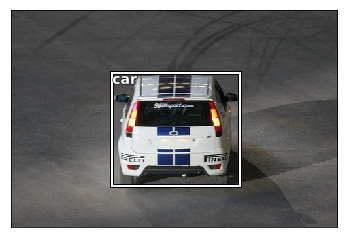

In [34]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

- `ax`: `show_img` returns the axis that the image is on
- `b = bb_hw(im0_a[0])`: turn my bounding box into hight and width
- `draw_rect`: draw the rectangle
- `draw_text`: draw the text. `b[:2]` is the top left, and `cats[im0_a[1]` is the class

We wanna package all of above up:

In [35]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

`def draw_im(im, ann)`: draws and image `im` with some annotations. Remmber, each ann has a bbox and a class
- `ax = show_img(im, figsize=(16,8))`: shows the image
- `for b,c in ann`: unpack or destructures each annotation into bbox and `b` and class `c`
    - `b = bb_hw(b)`: turns it into height and width
    - `draw_rect`: draws a rectangle
    - `draw_text`: draws text.

In [36]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

`def draw_idx(i)`: draw image of a particular index by
- `im_a = trn_anno[i]`: grabbing the image ID
- `im = open_image(IMG_PATH/trn_fns[i])`: openning it up
- ` draw_im(im, im_a)`: and then drawing image

(364, 480, 3)


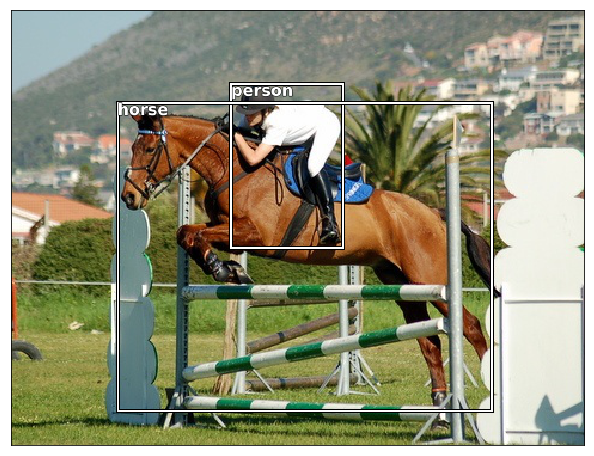

In [37]:
draw_idx(17)

*All of the above is Exploratory Data Analysis!*

## Devlop largest item classifier model

In [38]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

`def get_lrg(b)`: get the largest image by
- `b`: sorting the bounding boxes `b` using lambda function
- `lambda x: np.product(x[0][-2:]-x[0][:2])`: take the product of the last two items of my bbox list (i.e., bounding right hand corner) `x[0][-2:]` minus the first two items of my bbox list (i.e., the top left corner). So bottom right minus top left is the size. And if you take the product of those two things, you get the size of the bbox. Do in descending order `reverse=True`.


In [39]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

- `trn_lrg_anno`: first thing we want to do is to go through each of the bboxes in an image `trn_anno` and get the largest one `get_lrg(b)`. This is a dictionary comprehension. The key is the image ID `a`, and its value is the largest bbox.

Now we have a dictionary from image id to a single bounding box - the largest for that image.

Following is an example of the largest bounding box for this image.

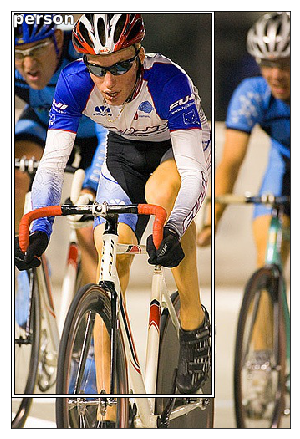

In [40]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

Create a temp directory, and create a CSV pather, which is a path to my large objects csv file:

In [41]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [42]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

Create a csv file using `pd.DataFrame`.
- give it a dictionary with
    - a name of a column `fn` and the lists of things in that column `[trn_fns[o] for o in trn_ids]`. And the category
    - `columns=['fn','cat']`: we are adjusting the order of columns. I.e., this is becasue a dictionary doesnt have an order, so we have to do manually.

In [43]:
f_model = resnet34
sz=224
bs=64

In [219]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

`crop_type=CropType.NO`: the default strategy for creating a 224x224 image is to first of resize it so that the smallest side is 224 and then take a random square crop during traiing. And during validation, we take the cetnre crop, unless we use data augmentation in which case we do a few random crops. BUT, for bboxes, we do not want to do that because, unlike an imagenet where the thing we care about is pretty much in the middle and it is pretty big, a lot of the stuff in object detection is quite small and close to the edge, like satellite images! So we could crop it out and that would be bad. So we chose `CropType` to be NO here. Therefore, to make it square, it squishes it instead

**Data Loaders**

We already know that inside our model data object `md` we have a training data loader `md.trn_dl` and a traing data set `md.trn_ds`. 

- data loaders are iterators. Each time you grab the next iteration of stuff you get a minibatch. And the minbach you get is whatever batchsize you asked for. By default, bs=64. In python the way you grab the next batch from an iterator is with `next`:

In [201]:
x,y=next(iter(md.val_dl))

- `iter`: says please grab an iterator out of this object `md.val_dl`
- `x,y`: our datasets behind our dataloaders always have an x (independent var) and the y (dependent variable). So this gets us a minibatch of x's and y's. We pass that to our `show_img` command, but we need to change because (1) it is not an numpy array, (2) it is not on the CPU, and (4) its shape is all wrong. I.e, we need 224x224x3. Also, the number are not btwn 0 and 1. The function `denorm` will fix things up including dimension orde, etc.

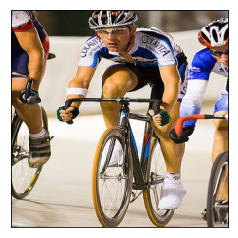

In [31]:
show_img(md.val_ds.denorm(to_np(x))[0]);

- `md.val_ds.denorm`: this function will undo everything. You pass it a ninibatch but turned into numpy first `to_np(x)` 

In [220]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [ ]:
lrf=learn.lr_find(1e-5,100)

When you LR finder graph looks like this, you can ask for more points on each end:

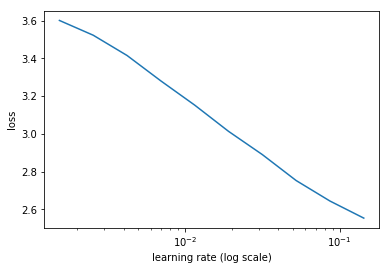

In [36]:
learn.sched.plot()

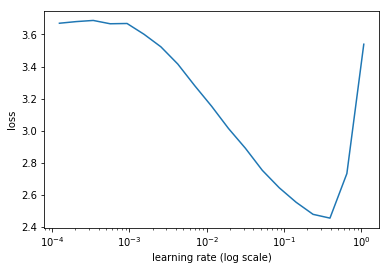

In [35]:
learn.sched.plot(n_skip=5, n_skip_end=1)

IN first plot above, by default, we remove the first and last few points. we fix that by:
- `n_skip=5`: skip 5 instead of 10 at the start
- `n_skip_end=1`: skip 1 instead of 5 at the end

In [43]:
lr = 2e-2

In [44]:
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.335532   0.6443     0.804838  



[0.6443001, 0.80483774095773697]

In [45]:
lrs = np.array([lr/1000,lr/100,lr])

In [46]:
learn.freeze_to(-2)

A Jupyter Widget

 84%|████████▍ | 27/32 [00:07<00:01,  3.76it/s, loss=4.99] 


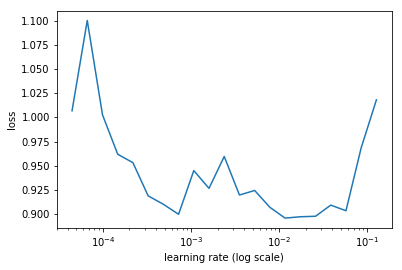

In [39]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [47]:
learn.fit(lrs/5, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.780925   0.575539   0.821064  



[0.57553864, 0.82106370478868484]

In [48]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate here. See mutliobject detection notebook.

In [49]:
learn.fit(lrs/5, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.609306   0.570568   0.821514  
    1      0.462856   0.574303   0.8128                    



[0.57430345, 0.81280048191547394]

Why are we stuck at 80 percent accuracy above? This is because a lot of the pascal dataset has lots of little things.

In [51]:
learn.save('clas_one')

In [221]:
learn.load('clas_one')

In [222]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

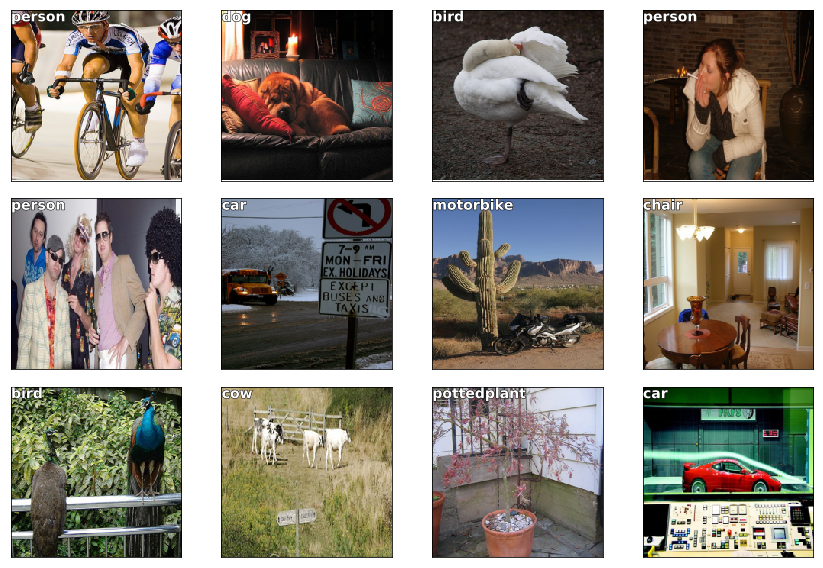

In [223]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

It's doing a pretty good job of classifying the largest object!

## Stage 2 - Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs (top left x and y, and bottom right x and y). So we can use a CSV with multiple 'labels' like below.

We just need to create a model with four activations, with a mean squared error loss function.   

In [160]:
BB_CSV = PATH/'tmp/bb.csv'

In [161]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [162]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [163]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell PyTorch that this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use `CropType.NO` because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [164]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [165]:
x,y=next(iter(md.val_dl))

In [166]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([  49.,    0.,  131.,  205.], dtype=float32)

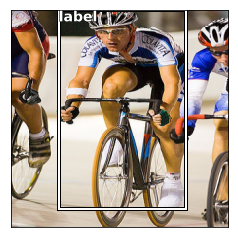

In [167]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [168]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

- `custom_head`: If you say my model has a custom head, the head being the thing that is added to the top of the model, then it is not goign to create any of that fully connnected network for you. It is not goign to add the adaptive average pooling for you. but insstead it will add whatever model you ask for, in this case `head_reg4`.
- `head_reg4`: this model flattens out the previous layer. Normally we would have a 7x7x512 in resnet 34. So this flattens that out into a single vector of length `25088`. So then we just add a linear layer that goes from 25088 to 4--which is our four outputs! We stick taht on top of our pretrained resnet34 model `ConvLearner.pretrained(f_model`.
- `learn.crit = nn.L1Loss()`: we are not going to usee MSE here. We are going to use L1Loss. L1Loss means that rather than adding up the squared errors, we add up the absolte values of the errors.

In [170]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

A Jupyter Widget

 78%|███████▊  | 25/32 [00:04<00:01,  6.16it/s, loss=395] 


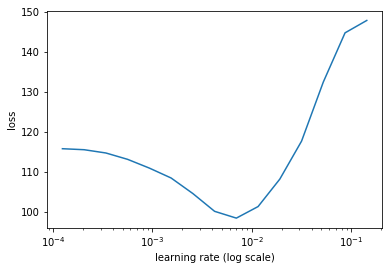

In [147]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [151]:
lr = 2e-3

In [152]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      49.523444  34.764141 
    1      36.864003  28.007317                           
    2      30.925234  27.230705                           



[27.230705]

In [153]:
lrs = np.array([lr/100,lr/10,lr])

In [154]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      102.406115 91141120000.0



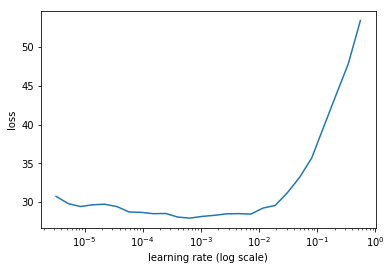

In [106]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [155]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      25.616161  22.83597  
    1      21.812624  21.387115                           
    2      17.867176  20.335539                           



[20.335539]

In [156]:
learn.freeze_to(-3)

In [157]:
learn.fit(lrs, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      16.571885  20.948696 
    1      15.072718  19.925312                           



[19.925312]

Our validatoin loss above is 19.925312. This is the mean of the absolute value of pixels we are off by.

In [158]:
learn.save('reg4')

In [89]:
learn.load('reg4')

In [97]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

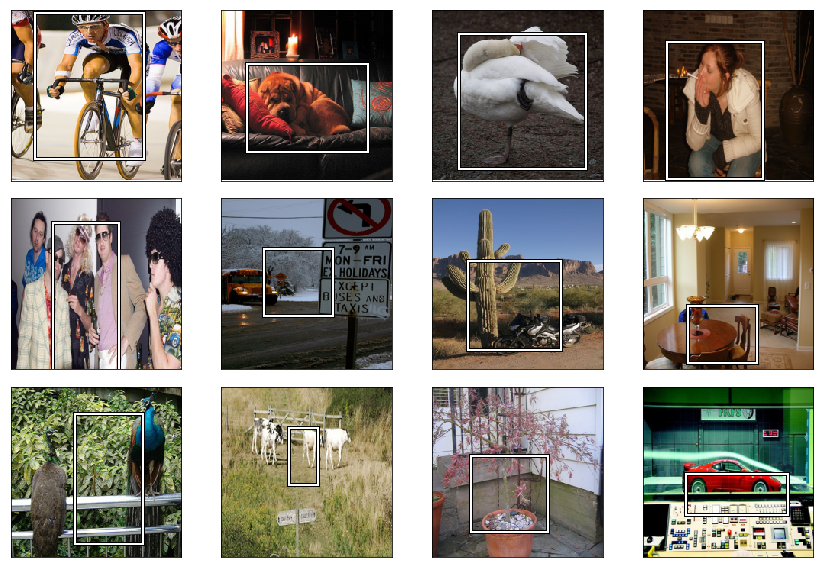

In [99]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

**Summmary of steps for training any neural network**
1. Get the data
2. Need some kind of architecture
3. We need a loss function

### Data

In [171]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [172]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [173]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [175]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [176]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [177]:
val_ds2[0][1]

(array([   0.,   49.,  205.,  180.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [179]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [180]:
x,y=next(iter(md.val_dl))

ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([   1.,   63.,  222.,  159.], dtype=float32)

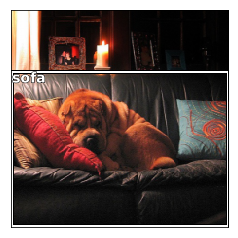

In [181]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

### Architecture

In [105]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

### Loss function

In [106]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

A Jupyter Widget

 97%|█████████▋| 31/32 [00:07<00:00,  4.32it/s, loss=920]


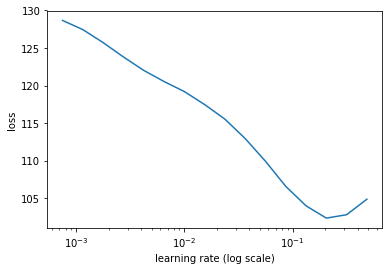

In [171]:
learn.lr_find()
learn.sched.plot()

In [107]:
lr=1e-2

In [193]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      73.927436  47.326687  0.799129   34.355363 
    1      52.524767  36.633926  0.821514   25.356636     
    2      42.088353  35.808929  0.840144   24.928916     



[35.808929, 0.84014423191547394, 24.928915977478027]

In [194]:
learn.save('reg1_0')

In [195]:
learn.freeze_to(-2)

In [196]:
lrs = np.array([lr/100, lr/10, lr])

A Jupyter Widget

 91%|█████████ | 29/32 [00:09<00:01,  2.99it/s, loss=308] 


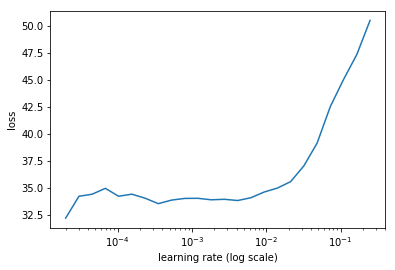

In [185]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [197]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      34.996194  36.883408  0.810998   23.902456 
    1      28.962542  33.961132  0.807542   21.788602     
    2      24.479901  31.829189  0.816256   20.760759     
    3      21.002628  31.217596  0.827524   20.065778     
    4      18.563346  31.386042  0.819712   19.966886     



[31.386042, 0.81971153616905212, 19.966886043548584]

In [198]:
learn.save('reg1_1')

In [353]:
learn.load('reg1_1')

In [199]:
learn.unfreeze()

In [200]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.8324    31.657162  0.813852   20.311439 
    1      16.053105  31.920698  0.819111   20.126827     
    2      15.587304  31.761778  0.813401   19.608653     
    3      14.946252  31.8496    0.82512    19.494941     
    4      14.286875  31.694134  0.813852   19.520903     
    5      13.687061  31.146765  0.810998   19.118674     
    6      12.972183  30.679935  0.802734   18.846736     
    7      12.234888  30.844444  0.812951   18.867411     
    8      11.729662  30.820433  0.8125     18.726339     
    9      11.324294  30.836037  0.812951   18.648762     



[30.836037, 0.81295072287321091, 18.648761749267578]

In [201]:
learn.save('reg1')

In [108]:
learn.load('reg1')

In [109]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [110]:
from scipy.special import expit

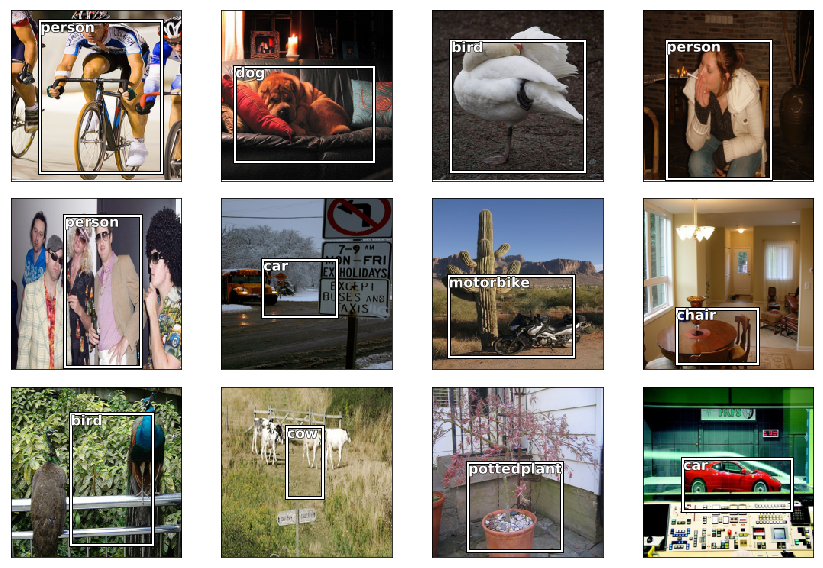

In [112]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## Summary Steps Review

1.	**Image classification**: Classify and localize WHAT is the largest object in each image.
2.	**Classification with localization:** WHERE is the object located in each image, using bounding boxes. 
3.	**Detection:** Detect and localize all objects in the image.

## Next Steps
- fold above code into multi-object project.